In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_01 import *

In [3]:
path= Path('../PCImages')

In [4]:
path2fm= '../FeatureMatsMerged/TheGreatCollection.txt'
path2colnames= 'FeatureMatIndex.txt'

In [5]:
fm= fm_from_txt(path2fm, path2colnames)
fm.shape

(56657, 105)

In [6]:
#export
class ToFloatTensor(object): 
    def __call__(self, img): return torch.from_numpy(np.array(img, dtype=np.float32, copy=False))

In [8]:
ds= CellDataSet(path, fm, label = 'label1', cell_phase = None, 
               trfms= [CenterCrop(), ToFloatTensor(), transforms.Normalize([0.5], [0.5])], 
               random_sample=100)

In [9]:
len(ds)

100

In [7]:
#export
import torchvision.models as models
from torch import nn

In [66]:
#export
class Resize(nn.Module):
    def __init__(self, size):
        super().__init__()
        self.size = size

    def forward(self, x): return x.view(-1, 1, self.size, self.size)

In [67]:
#export
def get_model(m, image_size, c = 7):
    m.conv1= nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False).cuda()
    m.fc= nn.Linear(in_features=512, out_features=c).cuda()
    return nn.Sequential(
        Resize(image_size),
        m
    )

In [13]:
model = get_model(models.resnet34(pretrained=True).cuda(), image_size=256, c=7)

In [11]:
#export
def accuracy(outb, yb): return (torch.argmax(outb, dim=1)==yb).float().mean()

In [70]:
#export
device = torch.device('cuda',0)

In [21]:
#export
class Learner():
    def __init__(self, dataset, model):
        self.ds= dataset 
        self.img_size, self.c= self.ds[0][0].shape[0], len(np.unique(self.ds.y))
        self.model= get_model(model.cuda(), image_size=self.img_size, c=self.c)
        self.loss= nn.CrossEntropyLoss()
        
    def fit(self, epochs=1, bs=32, lr = 1e-5):
        opt= torch.optim.Adam(self.model.parameters(), lr=lr)
        train_dl, valid_dl= ds2dls(self.ds, bs=bs)
        for epoch in range(epochs):
            self.model.train()
            for xb,yb in train_dl:
                xb= xb.to(device)
                yb= yb.to(device)
                loss = self.loss(self.model(xb), yb)
                loss.backward()
                opt.step()
                opt.zero_grad()

            self.model.eval()
            with torch.no_grad():
                tot_loss,tot_acc = 0.,0.
                for xb,yb in valid_dl:
                    xb= xb.to(device)
                    yb= yb.to(device)
                    pred = self.model(xb)
                    pred= pred.to(device)
                    tot_loss += self.loss(pred, yb)
                    tot_acc  += accuracy(pred,yb)
            nv = len(valid_dl)
            print(epoch, tot_loss/nv, tot_acc/nv)
        #return tot_loss/nv, tot_acc/nv

### Grayscale normalization:

In [25]:
ds= CellDataSet(path, fm, label = 'label1', cell_phase = None, trfms= [CenterCrop(size=256//2), ToFloatTensor()], 
               random_sample=1000)
learn= Learner(ds, models.resnet34(pretrained=True))

In [26]:
learn.fit(2, bs=16)

0 tensor(1.9066, device='cuda:0') tensor(0.3221, device='cuda:0')
1 tensor(1.5821, device='cuda:0') tensor(0.4663, device='cuda:0')


In [27]:
ds= CellDataSet(path, fm, label = 'label1', cell_phase = None, 
               trfms= [CenterCrop(size=128), transforms.Grayscale(num_output_channels=1), ToFloatTensor()], 
               random_sample=1000)
learn= Learner(ds, models.resnet34(pretrained=True))
learn.fit(2, bs=16)

0 tensor(1.4205, device='cuda:0') tensor(0.4712, device='cuda:0')
1 tensor(1.1595, device='cuda:0') tensor(0.5769, device='cuda:0')


### Image size:

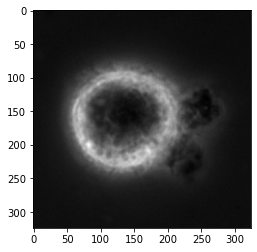

In [58]:
plt.imshow(ds[0][0].numpy(), cmap='gray');

In [28]:
ds= CellDataSet(path, fm, label = 'label1', cell_phase = None, 
               trfms= [CenterCrop(size=128), 
                       transforms.Grayscale(num_output_channels=1), 
                       ToFloatTensor()], 
               random_sample=1000)
learn= Learner(ds, models.resnet34(pretrained=True))
learn.fit(2, bs=16)

0 tensor(1.9318, device='cuda:0') tensor(0.2788, device='cuda:0')
1 tensor(1.8042, device='cuda:0') tensor(0.3750, device='cuda:0')


In [29]:
ds= CellDataSet(path, fm, label = 'label1', cell_phase = None, 
               trfms= [CenterCrop(size=256), 
                       transforms.Grayscale(num_output_channels=1), 
                       ToFloatTensor()], 
               random_sample=1000)
learn= Learner(ds, models.resnet34(pretrained=True))
learn.fit(2, bs=16)

0 tensor(1.5330, device='cuda:0') tensor(0.4712, device='cuda:0')
1 tensor(1.1586, device='cuda:0') tensor(0.6202, device='cuda:0')


In [30]:
ds= CellDataSet(path, fm, label = 'label1', cell_phase = None, 
               trfms= [CenterCrop(size=300), 
                       transforms.Grayscale(num_output_channels=1), 
                       ToFloatTensor()], 
               random_sample=1000)
learn= Learner(ds, models.resnet34(pretrained=True))
learn.fit(2, bs=16)

0 tensor(1.1083, device='cuda:0') tensor(0.6202, device='cuda:0')
1 tensor(0.8912, device='cuda:0') tensor(0.7163, device='cuda:0')


In [32]:
ds= CellDataSet(path, fm, label = 'label1', cell_phase = None, 
               trfms= [CenterCrop(size=400), 
                       transforms.Grayscale(num_output_channels=1), 
                       ToFloatTensor()], 
               random_sample=1000)
learn= Learner(ds, models.resnet34(pretrained=True))
learn.fit(2, bs=16)

0 tensor(1.1273, device='cuda:0') tensor(0.5433, device='cuda:0')
1 tensor(0.8559, device='cuda:0') tensor(0.7260, device='cuda:0')


In [33]:
ds= CellDataSet(path, fm, label = 'label1', cell_phase = None, 
               trfms= [CenterCrop(size=324), 
                       transforms.Grayscale(num_output_channels=1), 
                       ToFloatTensor()], 
               random_sample=1000)
learn= Learner(ds, models.resnet34(pretrained=True))
learn.fit(2, bs=16)

0 tensor(1.2644, device='cuda:0') tensor(0.5865, device='cuda:0')
1 tensor(1.0266, device='cuda:0') tensor(0.6731, device='cuda:0')


In [31]:
ds= CellDataSet(path, fm, label = 'label1', cell_phase = None, 
               trfms= [CenterCrop(size=350), 
                       transforms.Grayscale(num_output_channels=1), 
                       ToFloatTensor()], 
               random_sample=1000)
learn= Learner(ds, models.resnet34(pretrained=True))
learn.fit(2, bs=16)

0 tensor(0.9999, device='cuda:0') tensor(0.6587, device='cuda:0')
1 tensor(0.8308, device='cuda:0') tensor(0.7308, device='cuda:0')


### Cell phase:

In [59]:
ds= CellDataSet(path, fm, label = 'label1', cell_phase = 'trap', 
               trfms= [CenterCrop(size=350), 
                       transforms.Grayscale(num_output_channels=1), 
                       ToFloatTensor()], 
               random_sample=1000)
learn= Learner(ds, models.resnet34(pretrained=True))
learn.fit(2, bs=16)

0 tensor(1.0499, device='cuda:0') tensor(0.6202, device='cuda:0')
1 tensor(0.8433, device='cuda:0') tensor(0.6923, device='cuda:0')


In [60]:
ds= CellDataSet(path, fm, label = 'label1', cell_phase = 'stretch', 
               trfms= [CenterCrop(size=350), 
                       transforms.Grayscale(num_output_channels=1), 
                       ToFloatTensor()], 
               random_sample=1000)
learn= Learner(ds, models.resnet34(pretrained=True))
learn.fit(2, bs=16)

0 tensor(1.3196, device='cuda:0') tensor(0.5240, device='cuda:0')
1 tensor(0.9930, device='cuda:0') tensor(0.6683, device='cuda:0')


In [61]:
ds= CellDataSet(path, fm, label = 'label1', cell_phase = 'relax', 
               trfms= [CenterCrop(size=350), 
                       transforms.Grayscale(num_output_channels=1), 
                       ToFloatTensor()], 
               random_sample=1000)
learn= Learner(ds, models.resnet34(pretrained=True))
learn.fit(2, bs=16)

0 tensor(1.2336, device='cuda:0') tensor(0.6202, device='cuda:0')
1 tensor(1.0020, device='cuda:0') tensor(0.6875, device='cuda:0')


### Learning rate:

In [62]:
ds= CellDataSet(path, fm, label = 'label1', cell_phase = 'relax', 
               trfms= [CenterCrop(size=350), 
                       transforms.Grayscale(num_output_channels=1), 
                       ToFloatTensor()], 
               random_sample=1000)
learn= Learner(ds, models.resnet34(pretrained=True))
learn.fit(2, bs=16, lr=1e-4)

0 tensor(0.7182, device='cuda:0') tensor(0.7500, device='cuda:0')
1 tensor(0.9469, device='cuda:0') tensor(0.6971, device='cuda:0')


In [63]:
learn.fit(2, bs=16, lr=1e-4)

0 tensor(0.7900, device='cuda:0') tensor(0.7500, device='cuda:0')
1 tensor(0.9047, device='cuda:0') tensor(0.6683, device='cuda:0')


In [64]:
ds= CellDataSet(path, fm, label = 'label1', cell_phase = 'relax', 
               trfms= [CenterCrop(size=350), 
                       transforms.Grayscale(num_output_channels=1), 
                       ToFloatTensor()], 
               random_sample=1000)
learn= Learner(ds, models.resnet34(pretrained=True))
learn.fit(4, bs=16, lr=1e-6)

0 tensor(1.9658, device='cuda:0') tensor(0.2308, device='cuda:0')
1 tensor(1.8275, device='cuda:0') tensor(0.3077, device='cuda:0')
2 tensor(1.7147, device='cuda:0') tensor(0.3413, device='cuda:0')
3 tensor(1.6297, device='cuda:0') tensor(0.3654, device='cuda:0')


### Try DenseNet:

In [8]:
class Resize(nn.Module):
    def __init__(self, size):
        super().__init__()
        self.size = size

    def forward(self, x): return x.view(-1, 1, self.size, self.size)

In [9]:
def get_model(m, image_size, c = 7):
    m.features.conv0= nn.Conv2d(1, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False).cuda()
    m.classifier= nn.Linear(in_features=2208, out_features=c, bias=True).cuda()
    return nn.Sequential(
        Resize(image_size),
        m
    )

In [18]:
ds= CellDataSet(path, fm, label = 'label1', cell_phase = 'trap',
               trfms= [CenterCrop(size=256), transforms.Grayscale(num_output_channels=1), ToFloatTensor()], 
               random_sample=400)
learn= Learner(ds, models.densenet161(pretrained=True))
learn.fit(4, bs=4, lr=1e-4)

0 tensor(0.9877, device='cuda:0') tensor(0.6750, device='cuda:0')
1 tensor(1.1561, device='cuda:0') tensor(0.6000, device='cuda:0')
2 tensor(0.9258, device='cuda:0') tensor(0.6875, device='cuda:0')
3 tensor(0.8233, device='cuda:0') tensor(0.6500, device='cuda:0')


## Optimized parameters:

In [65]:
ds= CellDataSet(path, fm, label = 'label1', cell_phase = None, 
               trfms= [CenterCrop(size=350), 
                       transforms.Grayscale(num_output_channels=1), 
                       ToFloatTensor()], 
               random_sample=1000)
learn= Learner(ds, models.resnet34(pretrained=True))
learn.fit(8, bs=16, lr=1e-5)

0 tensor(1.1905, device='cuda:0') tensor(0.6490, device='cuda:0')
1 tensor(0.8972, device='cuda:0') tensor(0.7500, device='cuda:0')
2 tensor(0.8266, device='cuda:0') tensor(0.7500, device='cuda:0')
3 tensor(0.7322, device='cuda:0') tensor(0.7740, device='cuda:0')
4 tensor(0.7843, device='cuda:0') tensor(0.7308, device='cuda:0')
5 tensor(0.6908, device='cuda:0') tensor(0.7692, device='cuda:0')
6 tensor(0.7016, device='cuda:0') tensor(0.7548, device='cuda:0')
7 tensor(0.7003, device='cuda:0') tensor(0.7548, device='cuda:0')


In [71]:
!python notebook2script.py 02_learner.ipynb

Converted 02_learner.ipynb to exp/nb_02.py
